1. Convert clips to spectrograms
2. Convert spectrograms to numpy arrays
3. model!

In [3]:
import pandas as pd
import numpy as np
import os
import time
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pydub import AudioSegment

In [5]:
def create_spectrogram(wav_path):
    #y is an array representing the amplitude of the audio signal at each sample.
    #sr is the sampling rate (samples per second),
    y, sr = librosa.load(wav_path)
    spectrogram = librosa.stft(y)

    #Transforms to decibel scale (logarithmic), which gives more emphasis to amplitude changes in high volumes
    spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))
    return spectrogram_db
spectrogram = create_spectrogram('../raw_data/OffMenu263/0_163_4846_OffMenu263.wav')

In [5]:
def create_mel_spectrogram(wav_path):
    clip = librosa.load(wav_path)
    return librosa.feature.melspectrogram(y=clip)

wav_path = '../raw_data/test/0_4753_4846_OffMenu263.wav'
spectrogram = create_mel_spectrogram(wav_path)

ParameterError: Audio data must be of type numpy.ndarray

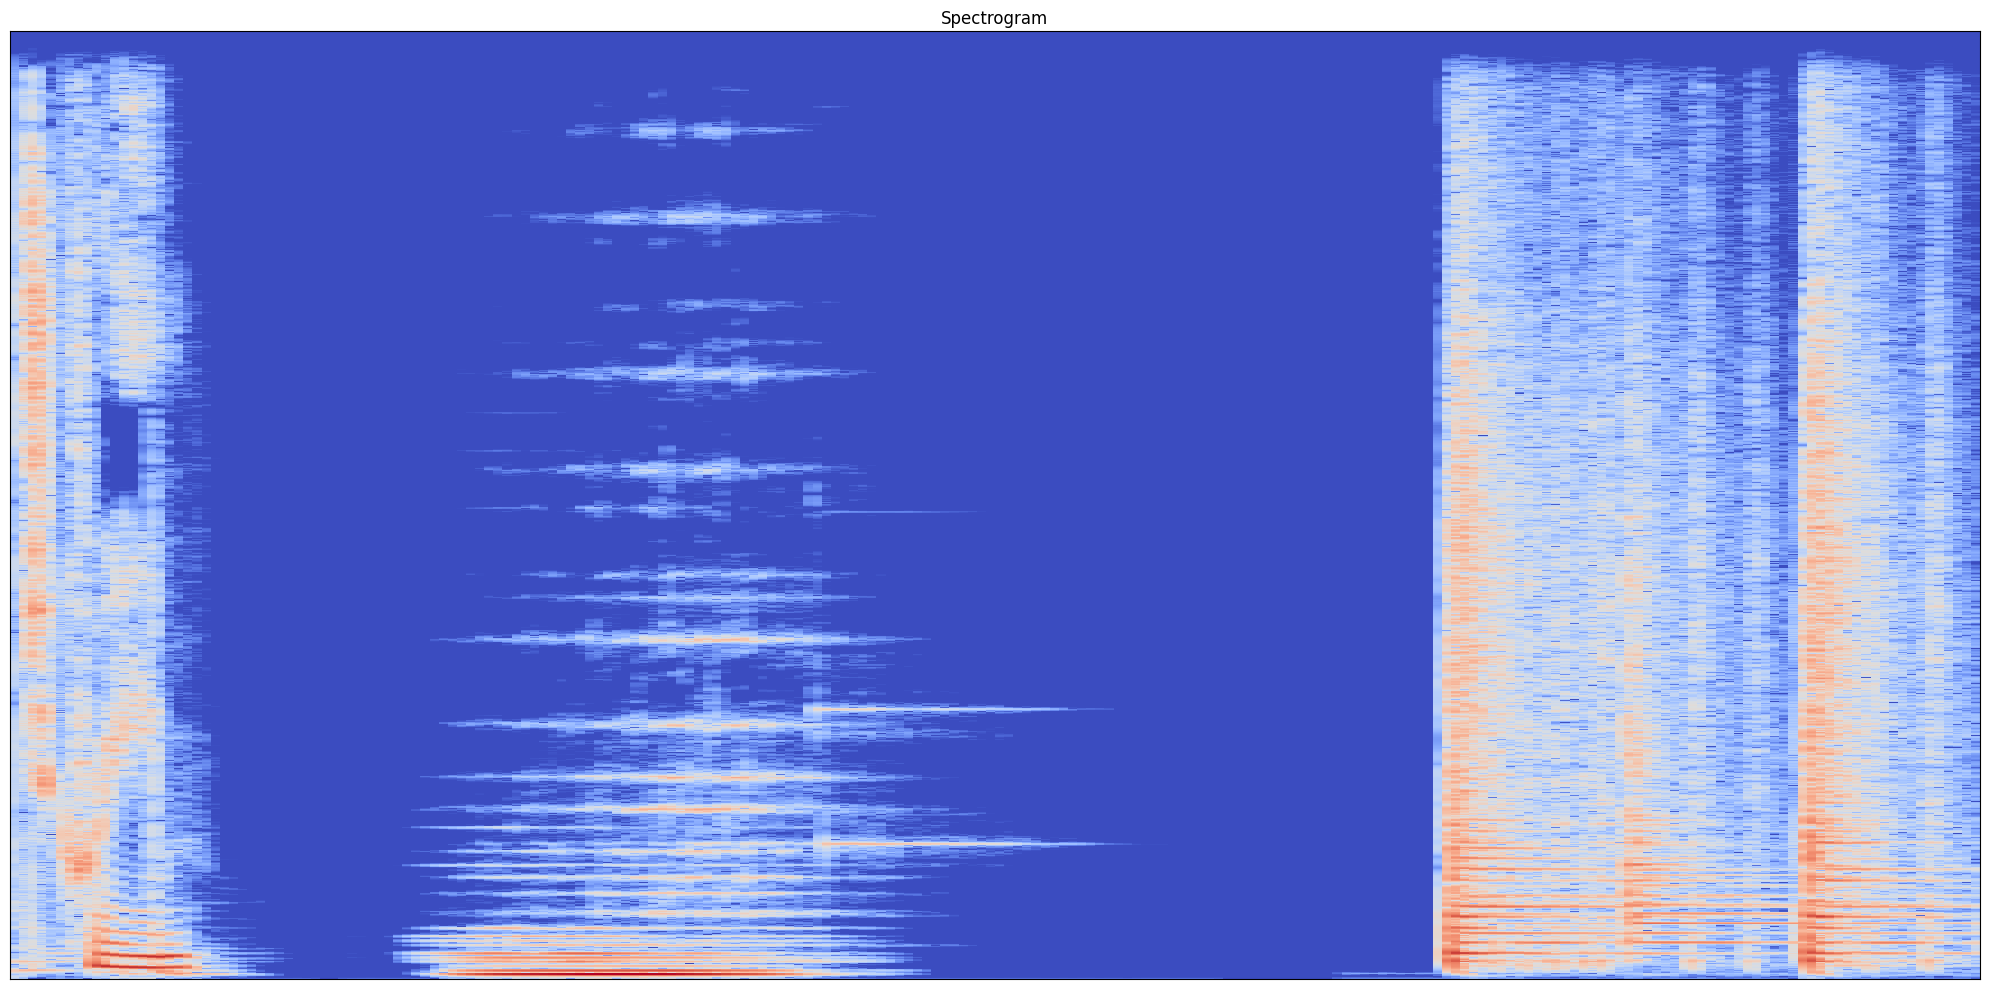

In [74]:
def plot_spectrogram(spectrogram_db, sr, hop_length):
    plt.figure(figsize=(20, 10))
    librosa.display.specshow(spectrogram_db, sr=sr, hop_length=hop_length)
    plt.title('Spectrogram')
    plt.tight_layout()
    # plt.savefig(output_path)
    # plt.close()
plot_spectrogram(spectrogram, 1, 1)

In [6]:
def spectrogram_to_numpy(spectrogram):
    return np.array(spectrogram)
spec_np = spectrogram_to_numpy(spectrogram)
spec_np

array([[ -9.822738, -16.014902, -42.129356, ..., -28.902256, -29.791231,
        -38.637375],
       [ -8.87643 , -17.128727, -27.600685, ..., -33.28881 , -33.41105 ,
        -36.14503 ],
       [ -7.378043,  -9.453039, -16.766506, ..., -28.524158, -26.56542 ,
        -27.123405],
       ...,
       [-42.800304, -42.800304, -42.800304, ..., -42.800304, -42.800304,
        -42.800304],
       [-42.800304, -42.800304, -42.800304, ..., -42.800304, -42.800304,
        -42.800304],
       [-42.800304, -42.800304, -42.800304, ..., -42.800304, -42.800304,
        -42.800304]], dtype=float32)

In [7]:
spec_np.shape

(1025, 216)

1. get np array
2. append to list
3.

In [18]:
folder_path = '../raw_data/test'

def process_folder_to_dataframe(folder_path):
    spectrograms = []
    filenames = []

    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)

            # Process the WAV file
            spectrogram = spectrogram_to_numpy(create_spectrogram(file_path))

            # Flatten the 2D spectrogram to 1D for DataFrame storage
            # flattened_spectrogram = spectrogram.flatten()

            spectrograms.append(flattened_spectrogram)
            filenames.append(filename)

    # Create DataFrame
    df = pd.DataFrame(spectrograms)

    # Add filename column
    df['filename'] = filenames

    return df

In [78]:
df = process_folder_to_dataframe(folder_path)
df

,0,1,2,3,4,5,6,7,8,9,...,221391,221392,221393,221394,221395,221396,221397,221398,221399,filename
0,-3.004013,-38.620155,-5.544467,-38.620155,-14.426379,-27.109531,-16.353020,-17.115213,-35.034515,-25.833553,...,-38.620155,-38.620155,-38.620155,-38.620155,-38.620155,-38.620155,-38.620155,-38.620155,-27.345478,0_4753_4846_OffMenu263.wav
1,-16.474377,-24.998322,-19.359947,-15.774928,-15.407915,-19.959875,-31.813072,-15.879588,-17.272095,-37.906631,...,-42.124962,-42.124962,-42.124962,-42.124962,-42.124962,-42.124962,-42.124962,-40.760593,-29.309448,1_15_4846_OffMenu263.wav
2,-15.914297,-35.617184,-26.379719,-11.318198,-13.677870,-41.761517,-40.338100,-37.914421,-29.119305,-21.567638,...,-41.986050,-41.986050,-41.986050,-41.986050,-41.986050,-41.986050,-41.986050,-41.986050,-31.500397,1_14_4846_OffMenu263.wav
3,-4.399884,-7.741452,-24.773396,-34.713493,-26.134596,-20.982172,-18.385580,-20.145500,-40.649353,-17.134325,...,-44.025951,-44.025951,-44.025951,-44.025951,-44.025951,-44.025951,-44.025951,-44.025951,-34.009651,1_17_4846_OffMenu263.wav
4,8.452059,1.944153,-42.287132,-14.836918,-16.856760,-24.192593,-19.978172,-34.745361,-15.133879,-28.099567,...,-42.287132,-42.287132,-42.287132,-42.287132,-42.287132,-42.287132,-42.287132,-42.287132,-42.287132,1_16_4846_OffMenu263.wav
5,-34.301830,-14.822865,-22.340271,-23.138496,-28.639830,-31.827524,-34.087200,-25.323929,-34.772446,-16.707399,...,-42.733086,-42.733086,-42.733086,-42.733086,-42.733086,-42.733086,-42.733086,-42.733086,-37.301613,1_10_4846_OffMenu263.wav
6,0.553982,-4.593257,-17.672834,-13.018007,-2.818073,0.743250,-8.414830,-21.337479,-17.415451,-10.810844,...,-45.208858,-45.208858,-45.208858,-45.208858,-45.208858,-45.208858,-45.208858,-45.208858,-45.208858,1_8_4846_OffMenu263.wav
7,9.129636,2.286752,-17.099663,-22.444839,-18.911764,-24.271873,-31.273365,-17.438715,-26.428118,-24.840237,...,-34.501614,-34.501614,-34.501614,-34.501614,-34.501614,-34.501614,-34.501614,-34.501614,-27.344170,0_4756_4846_OffMenu263.wav
8,-5.525146,-10.083547,-10.787598,-34.296398,-19.213673,-26.850594,-20.355305,-21.811312,-32.103630,-24.745531,...,-45.108334,-45.108334,-45.108334,-45.108334,-45.108334,-45.108334,-45.108334,-36.500698,-25.036270,1_9_4846_OffMenu263.wav
9,-8.334087,-20.562901,-21.384834,-42.864796,-33.474365,-25.168194,-42.864796,-41.439308,-29.190800,-21.855667,...,-42.864796,-42.864796,-42.864796,-42.864796,-42.864796,-42.864796,-42.864796,-34.002289,-22.550032,1_11_4846_OffMenu263.wav


In [79]:
df.isna().sum().sum()

np.int64(6150)

In [80]:
def seconds(x):
    return int(str(x).split('_')[1])

def duration(x):
    return int(str(x).split('_')[2])

df['is_ad'] = df['filename'].str[0]
df['seconds'] = df['filename'].apply(seconds)
df['duration'] = df['filename'].apply(duration)
df['progress'] = df['seconds'] / df['duration']
df

,0,1,2,3,4,5,6,7,8,9,...,221395,221396,221397,221398,221399,filename,is_ad,seconds,duration,progress
0,-3.004013,-38.620155,-5.544467,-38.620155,-14.426379,-27.109531,-16.353020,-17.115213,-35.034515,-25.833553,...,-38.620155,-38.620155,-38.620155,-38.620155,-27.345478,0_4753_4846_OffMenu263.wav,0,4753,4846,0.980809
1,-16.474377,-24.998322,-19.359947,-15.774928,-15.407915,-19.959875,-31.813072,-15.879588,-17.272095,-37.906631,...,-42.124962,-42.124962,-42.124962,-40.760593,-29.309448,1_15_4846_OffMenu263.wav,1,15,4846,0.003095
2,-15.914297,-35.617184,-26.379719,-11.318198,-13.677870,-41.761517,-40.338100,-37.914421,-29.119305,-21.567638,...,-41.986050,-41.986050,-41.986050,-41.986050,-31.500397,1_14_4846_OffMenu263.wav,1,14,4846,0.002889
3,-4.399884,-7.741452,-24.773396,-34.713493,-26.134596,-20.982172,-18.385580,-20.145500,-40.649353,-17.134325,...,-44.025951,-44.025951,-44.025951,-44.025951,-34.009651,1_17_4846_OffMenu263.wav,1,17,4846,0.003508
4,8.452059,1.944153,-42.287132,-14.836918,-16.856760,-24.192593,-19.978172,-34.745361,-15.133879,-28.099567,...,-42.287132,-42.287132,-42.287132,-42.287132,-42.287132,1_16_4846_OffMenu263.wav,1,16,4846,0.003302
5,-34.301830,-14.822865,-22.340271,-23.138496,-28.639830,-31.827524,-34.087200,-25.323929,-34.772446,-16.707399,...,-42.733086,-42.733086,-42.733086,-42.733086,-37.301613,1_10_4846_OffMenu263.wav,1,10,4846,0.002064
6,0.553982,-4.593257,-17.672834,-13.018007,-2.818073,0.743250,-8.414830,-21.337479,-17.415451,-10.810844,...,-45.208858,-45.208858,-45.208858,-45.208858,-45.208858,1_8_4846_OffMenu263.wav,1,8,4846,0.001651
7,9.129636,2.286752,-17.099663,-22.444839,-18.911764,-24.271873,-31.273365,-17.438715,-26.428118,-24.840237,...,-34.501614,-34.501614,-34.501614,-34.501614,-27.344170,0_4756_4846_OffMenu263.wav,0,4756,4846,0.981428
8,-5.525146,-10.083547,-10.787598,-34.296398,-19.213673,-26.850594,-20.355305,-21.811312,-32.103630,-24.745531,...,-45.108334,-45.108334,-45.108334,-36.500698,-25.036270,1_9_4846_OffMenu263.wav,1,9,4846,0.001857
9,-8.334087,-20.562901,-21.384834,-42.864796,-33.474365,-25.168194,-42.864796,-41.439308,-29.190800,-21.855667,...,-42.864796,-42.864796,-42.864796,-34.002289,-22.550032,1_11_4846_OffMenu263.wav,1,11,4846,0.002270


Why are there nans? 
Next steps:
  Use google collab
  start using data from gcloud?
  

In [21]:
### Normalizing pixels' intensities
# size_of_image = 255
# X_train = data_train / size_of_image
# X_train_small = data_train_small / size_of_image
# X_test = data_test / size_of_image
# X_test_small = data_test_small / size_of_image

### Encoding the labels
# from tensorflow.keras.utils import to_categorical
# y_train = to_categorical(labels_train, 10)
# y_train_small = to_categorical(labels_train_small, 10)
# y_test = to_categorical(labels_test, 10)
# y_test_small = to_categorical(labels_test_small, 10)

NameError: name 'data_train' is not defined

In [13]:
Train the model

SyntaxError: invalid syntax (3386306996.py, line 1)

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
def initialize_model():
    '''instanciate and return the CNN architecture of your choice with less than 150,000 params'''
    model = models.Sequential()

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(32, (1,1), input_shape=(32, 32, 3), activation="relu", padding="same")),
    layers.Dropout(0.3),
    model.add(layers.MaxPool2D(pool_size=(2,2))) ,

    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(32, (1,1), activation="relu", padding="same"))
    layers.Dropout(0.3),
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Third Convolution & MaxPooling
    model.add(layers.Conv2D(64, (1,1), activation="relu", padding="same"))
    # model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Fourth Convolution & MaxPooling
    model.add(layers.Conv2D(64, (1,1), activation="relu", padding="same"))
    # model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(100, activation='relu'))

    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(10, activation='softmax'))
    #dropouts

    return model

In [ ]:
def compile_model(model):
    '''return a compiled model suited for the CIFAR-10 task'''
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    return model

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
model = compile_model(initialize_model())

es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.3, callbacks=[es], verbose=1)

In [ ]:
plot_history(history)

In [ ]:
model.evaluate(X_test_small, y_test_small)